In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
    confusion_matrix, mean_squared_error, r2_score
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'xgboost'

# Loading the Data

In [87]:
with open('logins.json') as file:
    data = json.load(file)
    


# Exploratory Data Analysis 

### Aggregate the login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize theunderlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [88]:
#Convert Json file to pandas dataframe
df = pd.DataFrame(data)
print(df)

                login_time
0      1970-01-01 20:13:18
1      1970-01-01 20:16:10
2      1970-01-01 20:16:37
3      1970-01-01 20:16:36
4      1970-01-01 20:26:21
...                    ...
93137  1970-04-13 18:50:19
93138  1970-04-13 18:43:56
93139  1970-04-13 18:54:02
93140  1970-04-13 18:57:38
93141  1970-04-13 18:54:23

[93142 rows x 1 columns]


In [90]:
# Create a new column with a value of 1 for each login event
df['count'] = 1

In [92]:
# Convert the 'login_time' column to Pandas datetime format
df['login_time'] = pd.to_datetime(df['login_time'])

In [93]:
# Set the 'login_time' column as the new index for the DataFrame and select only the 'count' column
df = df.set_index('login_time')

In [94]:
# Resample data in 15-minute increments and aggregate with sum
df_agg = df.resample('15T').sum()

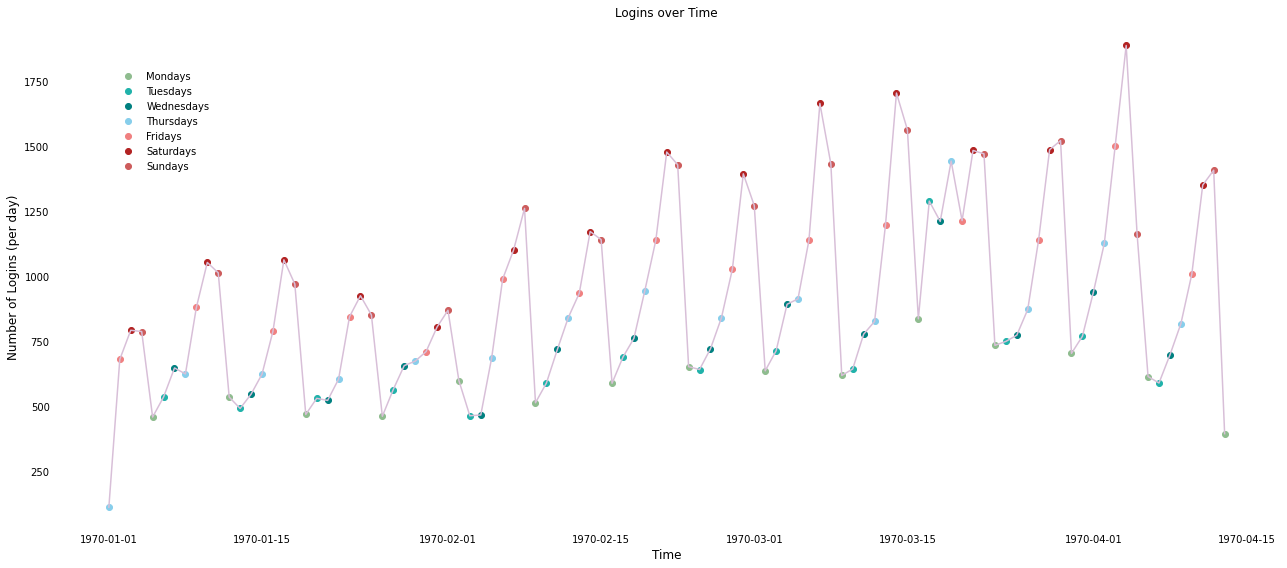

In [104]:
daily = df.resample('D').sum()
mondays = daily[daily.index.weekday == 0]
tuesdays = daily[daily.index.weekday == 1]
wednesdays = daily[daily.index.weekday == 2]
thursdays = daily[daily.index.weekday == 3]
fridays = daily[daily.index.weekday == 4]
saturdays = daily[daily.index.weekday == 5] # 5 represents Saturday
sundays = daily[daily.index.weekday == 6] # 6 represents Sunday

# Set the figsize
plt.figure(figsize=(18, 8))

plt.scatter(mondays.index, mondays['count'], label = 'Mondays', color='darkseagreen')
plt.scatter(tuesdays.index, tuesdays['count'], label = 'Tuesdays', color='lightseagreen')
plt.scatter(wednesdays.index, wednesdays['count'], label = 'Wednesdays', color='teal')
plt.scatter(thursdays.index, thursdays['count'], label = 'Thursdays', color='skyblue')
plt.scatter(fridays.index, fridays['count'], label = 'Fridays', color='lightcoral')
plt.scatter(saturdays.index, saturdays['count'], label = 'Saturdays', color='firebrick')
plt.scatter(sundays.index, sundays['count'], label = 'Sundays', color='indianred')
plt.plot(daily.index, daily['count'], linestyle='-', color='thistle')

# Remove the spines of the plot & little ticks on the x-axis & y-axis
sns.despine(bottom=True, left=True)
plt.tick_params(which='both', length=0)


plt.xlabel('Time', fontsize = 12)
plt.ylabel('Number of Logins (per day)', fontsize = 12)
plt.title('Logins over Time', fontsize = 12)

plt.legend(loc=(0.05,0.7), fontsize = 10, frameon=False)
plt.tight_layout()

In [107]:
df_hourly = df.resample('H').sum()
df_hourly.head()

,count
login_time,
1970-01-01 20:00:00,24
1970-01-01 21:00:00,9
1970-01-01 22:00:00,21
1970-01-01 23:00:00,58
1970-01-02 00:00:00,53


In [108]:
df_hourly['hour'] = df_hourly.index.hour
df_hourly['day'] = df_hourly.index.weekday

df_hourly = df_hourly.rename(columns={'count': 'login_count'})
df_hourly.head()

,login_count,hour,day
login_time,,,
1970-01-01 20:00:00,24,20,3
1970-01-01 21:00:00,9,21,3
1970-01-01 22:00:00,21,22,3
1970-01-01 23:00:00,58,23,3
1970-01-02 00:00:00,53,0,4


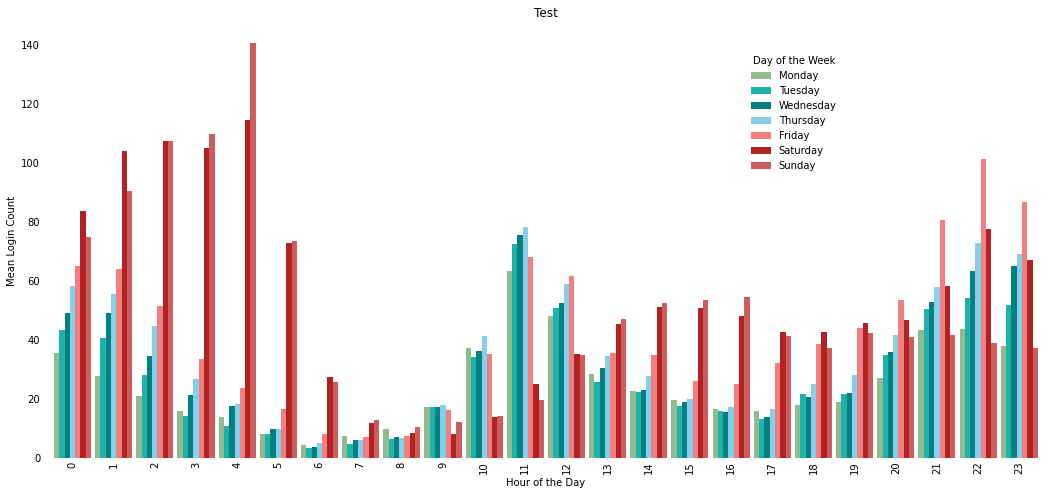

In [109]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = ['darkseagreen', 'lightseagreen', 'teal', 'skyblue', 'lightcoral', 'firebrick', 'indianred']

grouped = df_hourly.groupby(['hour', 'day']).mean()
grouped_unstacked = grouped.unstack()

ax = grouped_unstacked.plot(kind='bar', figsize=(18, 8), width=0.9, color=colors)

# Remove the spines of the plot & little ticks on the x-axis & y-axis
sns.despine(bottom=True, left=True)
plt.tick_params(which='both', length=0)

ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Mean Login Count')
ax.legend(labels=days, loc=(0.7,0.65), fontsize=10, frameon=False, title='Day of the Week')
ax.set_title('Test', fontsize=12)
plt.show()

In [110]:
grouped_unstacked.head(20)

login_count                                                          \
day            0          1          2          3          4           5   
hour                                                                       
0      35.400000  43.357143  49.071429  58.285714  65.000000   83.600000   
1      27.600000  40.428571  49.000000  55.500000  63.800000  104.133333   
2      20.800000  28.142857  34.428571  44.642857  51.400000  107.200000   
3      15.733333  14.142857  21.357143  26.785714  33.466667  104.933333   
4      13.733333  10.642857  17.500000  18.214286  23.533333  114.600000   
5       8.066667   8.071429   9.642857   9.714286  16.333333   72.866667   
6       4.400000   3.285714   3.428571   4.785714   8.066667   27.200000   
7       7.400000   4.571429   6.000000   5.785714   7.000000   11.866667   
8       9.800000   6.285714   7.071429   6.785714   7.266667    8.466667   
9      17.066667  17.285714  17.142857  17.928571  16.000000    7.866667   
10     37.200000  34.214286  36.285714  41.285714  35.133333   13.600000   
11     63.133333  72.500000  75.500000  78.357143  67.933333   24.800000   
12     48.133333  50.714286  52.285714  58.857143  61.733333   35.200000   
13     28.400000  25.785714  30.285714  34.571429  35.533333   45.266667   
14     22.466667  22.071429  22.785714  27.714286  34.800000   51.000000   
15     19.533333  17.642857  18.785714  20.000000  26.000000   50.866667   
16     16.600000  15.642857  15.285714  17.285714  24.800000   47.866667   
17     15.866667  13.071429  13.714286  16.571429  32.000000   42.733333   
18     17.800000  21.642857  20.500000  25.071429  38.466667   42.533333   
19     18.714286  21.500000  21.857143  28.000000  43.866667   45.600000   

                  
day            6  
hour              
0      74.866667  
1      90.333333  
2     107.200000  
3     109.800000  
4     140.466667  
5      73.466667  
6      25.466667  
7      12.800000  
8      10.200000  
9      12.000000  
10     14.000000  
11     19.466667  
12     34.800000  
13     46.933333  
14     52.400000  
15     53.466667  
16     54.533333  
17     41.200000  
18     37.133333  
19     42.133333

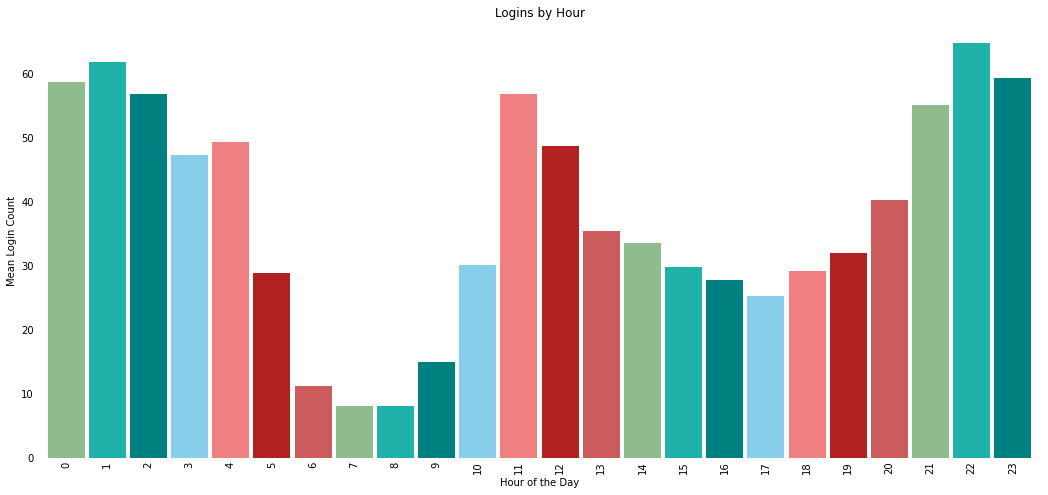

In [111]:
grouped_hr = df_hourly.groupby('hour')['login_count'].mean()
ax = grouped_hr.plot(kind='bar', figsize=(18, 8), width=0.9, color=colors)

# Remove the spines of the plot & little ticks on the x-axis & y-axis
sns.despine(bottom=True, left=True)
plt.tick_params(which='both', length=0)

ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Mean Login Count')
ax.set_title('Logins by Hour', fontsize=12)
plt.show()

In [113]:
# Compute the rolling average of login counts over a 24-hour window
rolling_avg = df_agg.rolling(window=96).mean()

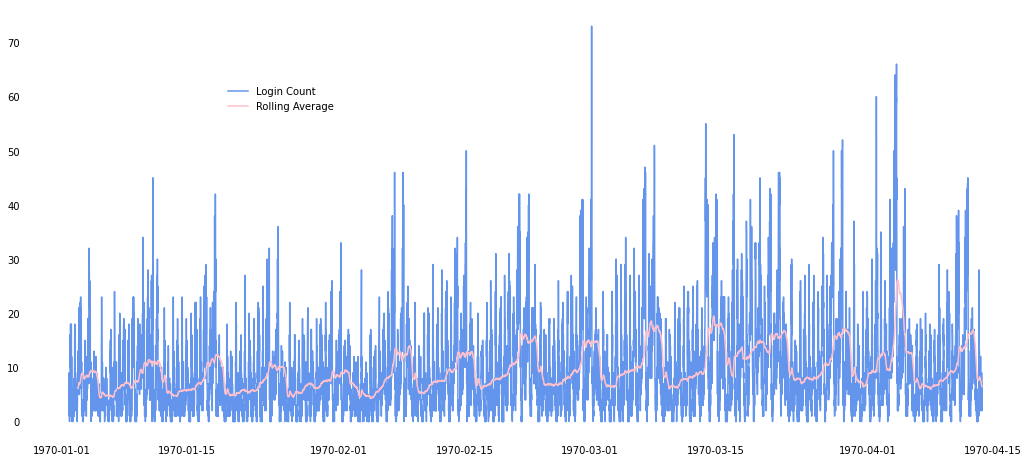

In [116]:
# Set the figsize
plt.figure(figsize=(18, 8))

# Plot the login counts and rolling average on the same plot
plt.plot(df_agg.index, 'count', data=df_agg, linestyle='-', color='cornflowerblue')
plt.plot(df_agg.index, 'count', data=rolling_avg, linestyle='-', color='pink')
plt.legend(['Login Count', 'Rolling Average'], frameon=False, loc=(0.2,0.75), fontsize=10)

# Remove the spines of the plot & little ticks on the x-axis & y-axis
sns.despine(bottom=True, left=True)
plt.tick_params(which='both', length=0)

plt.show()

## Part 2 ‐ Experiment and metrics design

In [117]:
df = pd.read_json('ultimate_data_challenge.json')

In [118]:
# Change signup date and last trip date to datetime.
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [119]:
df['phone'] = df['phone'].fillna('Unknown')

In [120]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00


In [121]:
# Replace NaNs with mean in avg_rating_of_driver column
avg_rating_of_driver_mean = df['avg_rating_of_driver'].mean()
df['avg_rating_of_driver'].fillna(avg_rating_of_driver_mean, inplace=True)

# Replace NaNs with mean in avg_rating_by_driver column
avg_rating_by_driver_mean = df['avg_rating_by_driver'].mean()
df['avg_rating_by_driver'].fillna(avg_rating_by_driver_mean, inplace=True)

In [122]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,50000.0,4.601559,0.564977,1.0,4.50,4.70,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,50000.0,4.778158,0.445753,1.0,4.70,5.00,5.00,5.00


In [123]:
df.sort_values(by='trips_in_first_30_days', ascending=False).head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8
99,Astapor,73,2014-01-27,4.9,1.00,2014-03-05,Android,0.0,True,89.7,2.86,4.9
3030,Winterfell,71,2014-01-06,4.9,1.06,2014-06-28,iPhone,2.9,True,85.9,2.32,4.8
29070,Astapor,63,2014-01-10,4.0,1.07,2014-06-29,iPhone,7.3,True,83.3,1.45,4.6
48804,Astapor,58,2014-01-24,4.4,1.04,2014-06-05,iPhone,3.1,True,77.6,2.30,4.7
45489,Astapor,56,2014-01-28,4.8,1.01,2014-04-23,iPhone,1.3,True,78.8,3.65,4.4
36917,Winterfell,56,2014-01-26,4.8,1.01,2014-06-30,iPhone,2.2,False,73.1,3.51,4.8
29043,King's Landing,55,2014-01-22,4.8,1.03,2014-06-30,iPhone,4.8,True,66.5,3.39,4.6
17942,Winterfell,55,2014-01-07,4.6,1.03,2014-06-25,iPhone,5.3,True,68.0,3.27,4.7
31047,Winterfell,54,2014-01-25,4.9,1.10,2014-06-29,iPhone,9.1,True,83.0,2.19,4.5


In [124]:
# 125 trips seems suspicous. Let's drop it. 
df = df[df['trips_in_first_30_days'] <= 100]

In [125]:
df.sort_values(by='avg_surge', ascending=False).head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
13861,Winterfell,1,2014-01-01,1.000000,8.00,2014-01-01,iPhone,100.0,False,100.0,5.77,5.0
30477,Winterfell,1,2014-01-01,5.000000,5.75,2014-01-01,iPhone,100.0,False,100.0,1.98,5.0
19191,Winterfell,1,2014-01-10,5.000000,5.00,2014-01-11,Android,100.0,False,100.0,3.37,5.0
2817,Winterfell,0,2014-01-02,5.000000,5.00,2014-02-05,iPhone,100.0,False,100.0,3.18,5.0
49383,Winterfell,1,2014-01-10,4.601559,5.00,2014-01-11,iPhone,100.0,False,100.0,2.40,5.0
47052,Winterfell,1,2014-01-09,4.601559,5.00,2014-01-11,Android,100.0,False,100.0,2.96,5.0
21894,Winterfell,1,2014-01-10,4.601559,5.00,2014-01-11,Android,100.0,False,100.0,2.46,4.0
1405,Winterfell,1,2014-01-08,5.000000,4.75,2014-01-21,iPhone,100.0,False,100.0,6.46,5.0
10546,Winterfell,0,2014-01-03,4.601559,4.50,2014-06-21,iPhone,100.0,False,0.0,2.70,5.0
15334,Winterfell,0,2014-01-13,4.601559,4.50,2014-06-18,iPhone,100.0,False,100.0,1.40,5.0


In [126]:
df.sort_values(by='surge_pct', ascending=False).head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
42177,King's Landing,1,2014-01-18,3.000000,2.25,2014-01-20,iPhone,100.0,False,0.0,3.09,5.000000
2202,Winterfell,0,2014-01-18,4.601559,2.00,2014-05-11,iPhone,100.0,False,0.0,9.91,5.000000
31237,King's Landing,0,2014-01-30,5.000000,1.25,2014-04-13,Android,100.0,False,0.0,17.20,5.000000
1021,King's Landing,0,2014-01-23,4.601559,1.75,2014-06-13,iPhone,100.0,True,100.0,2.33,4.778158
45469,Winterfell,2,2014-01-10,4.601559,2.13,2014-02-08,Android,100.0,False,100.0,2.32,5.000000
11918,Astapor,1,2014-01-23,4.601559,2.25,2014-01-24,iPhone,100.0,False,100.0,2.32,5.000000
27885,Winterfell,0,2014-01-23,5.000000,1.25,2014-06-28,iPhone,100.0,False,0.0,7.68,5.000000
31239,Astapor,1,2014-01-15,5.000000,2.50,2014-01-16,iPhone,100.0,False,100.0,1.15,5.000000
5040,Astapor,1,2014-01-17,4.601559,2.50,2014-01-19,iPhone,100.0,False,0.0,1.19,1.000000
31245,King's Landing,0,2014-01-31,5.000000,1.25,2014-06-14,Android,100.0,False,0.0,0.38,5.000000


In [127]:
df.sort_values(by='avg_dist', ascending=False).head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
20701,Astapor,0,2014-01-25,4.601559,1.0,2014-06-26,Android,0.0,False,100.0,160.96,4.778158
534,King's Landing,0,2014-01-04,4.601559,1.0,2014-03-09,Unknown,0.0,False,0.0,129.89,5.000000
1302,Winterfell,1,2014-01-30,5.000000,1.0,2014-01-30,iPhone,0.0,False,100.0,79.69,5.000000
22290,Astapor,0,2014-01-12,5.000000,1.0,2014-06-26,iPhone,0.0,True,100.0,79.34,5.000000
47595,King's Landing,0,2014-01-25,5.000000,1.0,2014-06-09,iPhone,0.0,True,0.0,77.13,5.000000
36625,Astapor,2,2014-01-19,5.000000,1.0,2014-01-22,iPhone,0.0,False,100.0,73.88,3.000000
22096,Astapor,0,2014-01-17,4.601559,1.0,2014-05-01,iPhone,0.0,True,100.0,72.20,5.000000
1493,Astapor,1,2014-01-26,5.000000,1.0,2014-01-27,iPhone,0.0,False,100.0,72.08,5.000000
19197,Astapor,2,2014-01-17,4.700000,1.0,2014-05-14,iPhone,0.0,True,100.0,71.38,5.000000
42835,Winterfell,0,2014-01-10,5.000000,1.0,2014-06-28,Android,0.0,False,100.0,70.48,5.000000


In [128]:
# find the date the data was pulled
pull_date = df.last_trip_date.max()

# determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

# add active status to dataframe 0= inactive, 1 = active
df['active_status'] = (df.last_trip_date > cut_off_day).astype('int')

# add dummies to categorical data
df = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])

In [129]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active_status,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,0,1,0


In [130]:
num_active = df.active_status.sum()
percent_active = num_active / len(df.active_status) * 100
print(f'The percentage of active users is {round(percent_active, 2)}%.')

The percentage of active users is 36.62%.


In [131]:
# Define features and target (y)
X = df.drop(['active_status','signup_date', 'last_trip_date'], axis=1)
y = df.active_status

# Change uint8 data tpes to int
uint8_cols = X.select_dtypes(include='uint8').columns
X[uint8_cols] = X[uint8_cols].astype('int')

# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=123)

In [132]:
# Create a logistic regression object
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Train the model on the training data (scaled data)
lr.fit(X_train, y_train)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test)

# Calculate the metrics
lr_acc = round(accuracy_score(y_test, y_pred),2)
lr_prec = round(precision_score(y_test, y_pred),2)
lr_rec = round(recall_score(y_test, y_pred),2)
lr_f1 = round(f1_score(y_test, y_pred),2)
lr_roc_auc = round(roc_auc_score(y_test, y_pred),2)

# Print the metrics
print("Accuracy:", lr_acc)
print("Precision:", lr_prec)
print("Recall:", lr_rec)
print("F1 score:", lr_f1)
print("ROC-AUC score:", lr_roc_auc)

Accuracy: 0.71
Precision: 0.59
Recall: 0.67
F1 score: 0.62
ROC-AUC score: 0.7
